In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

In [2]:
H = 100
W = 100
h = H-1
w = W-1

n_min = 2
n_max = 6

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.56933295 0.83333333 0.15666667 0.15666667]
 [0.49325555 0.5        0.19972809 0.19972809]
 [0.34863202 0.16666667 0.16552785 0.26227173]]
[1. 2. 0.]


In [3]:
anchor_boxes = np.array([
    [0.5,0.5],
    [0.5,0.25],
    [0.25,0.5],
    [0.25,0.25],
    [0.25,0.125],
    [0.125,0.25],
    [0.125,0.125]
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = (j+0.5)/W
        anchors[i,j,:,1] = (i+0.5)/H
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

W0808 14:43:09.896932 140085016471296 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


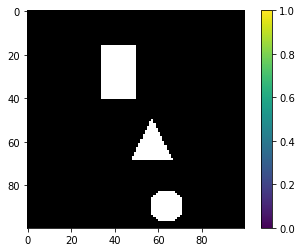

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 100
lr         = 0.0001
print_step = 10

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,3], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=3, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=30, hidden_size=256)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_mean(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = tf.reduce_mean(y_weights_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0808 14:43:20.031796 140085016471296 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0808 14:43:20.033890 140085016471296 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:13: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0808 14:43:20.034965 140085016471296 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0808 14:43:20.102222 140085016471296 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Mean:0", shape=(), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,3))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l = sess.run(loss, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f}".format(i,l))

iteration 0: loss=4.772
iteration 10: loss=4.810
iteration 20: loss=4.682
iteration 30: loss=4.784
iteration 40: loss=4.647
iteration 50: loss=4.489
iteration 60: loss=4.717
iteration 70: loss=4.601
iteration 80: loss=4.513
iteration 90: loss=4.548


In [10]:
out_box, out_obj = sess.run([rpn_box,rpn_obj], {x_tf:x})

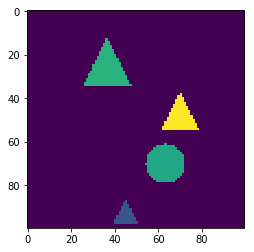

0


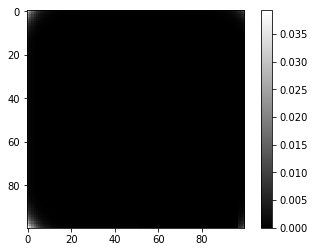

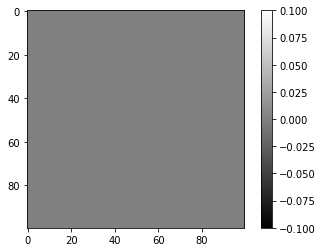

1


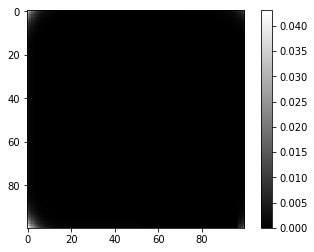

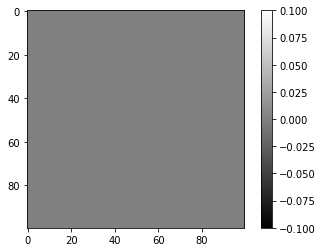

2


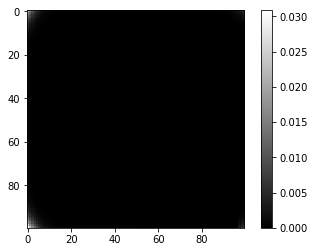

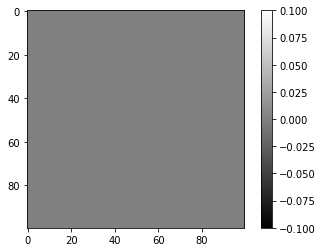

3


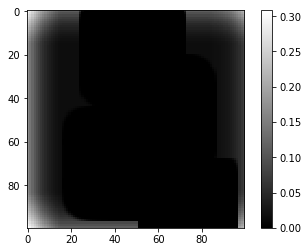

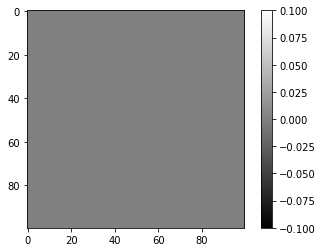

4


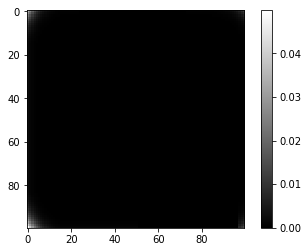

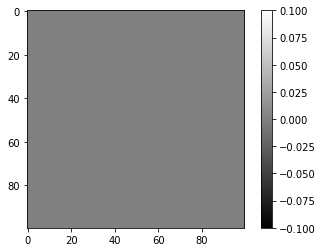

5


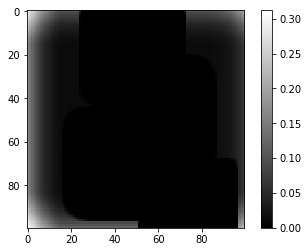

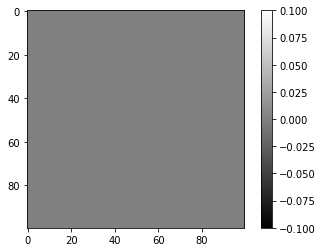

6


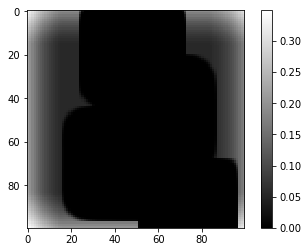

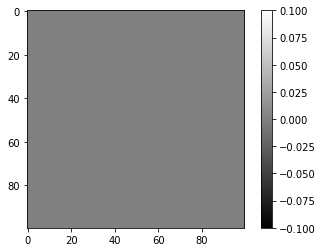

In [15]:
lab = gt_labels.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,1], cmap='gray')
    plt.colorbar()
    plt.show()

10.0